In [1]:
import pandas as pd
import datetime
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import typing
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2


In [2]:
data = pd.read_csv('../DATA/processed/dataset.csv', parse_dates=['date'])
data = data.set_index('date')

In [3]:
last_week = data[str(datetime.date.today()-datetime.timedelta(days=8)):str(datetime.date.today()-datetime.timedelta(days=1))]

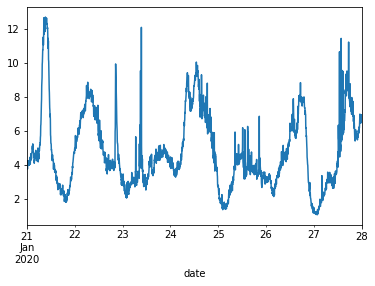

In [4]:
last_week.P1.plot()

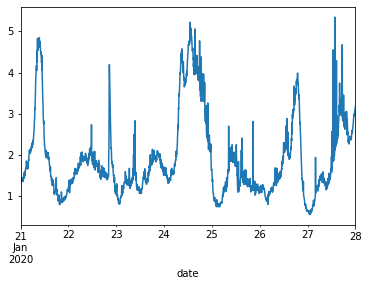

In [5]:
last_week.P2.plot()

In [6]:
wind_dir = {'Ветер, дующий с востока': 0,
            'Ветер, дующий с востоко-северо-востока': 45/2,
            'Ветер, дующий с северо-востока': 45,
            'Ветер, дующий с северо-северо-востока': 45 + 45/2,
            'Ветер, дующий с севера': 90,
            'Ветер, дующий с северо-северо-запад': 90 + 45/2,
            'Ветер, дующий с северо-запада': 135,
            'Ветер, дующий с западо-северо-запада': 135 + 45/2,
            'Ветер, дующий с запада': 180,
            'Ветер, дующий с западо-юго-запада': 180+45/2,
            'Ветер, дующий с юго-запада': 225,
            'Ветер, дующий с юго-юго-запада': 225 + 45/2,
            'Ветер, дующий с юга': 270,
            'Ветер, дующий с юго-юго-востока': 270 + 45/2,
            'Ветер, дующий с юго-востока': 315,
            'Ветер, дующий с востоко-юго-востока': 315 + 45/2,
            'Штиль, безветрие': None,
            }


def prepare_features(data: pd.DataFrame) -> pd.DataFrame:
    """Features preparation for anomaly detection and clustering"""
    # textual values encoding
    data['wind_direction'] = data.wind_direction.map(wind_dir)
    data['wind_direction'] = data.wind_direction.fillna(method='pad')
    data['prec_amount'] = data.prec_amount.fillna(value=0)
    data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
    data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
    data['prec_amount'] = data.prec_amount.astype(float)

    data['dew_point_diff'] = data.temperature - data.dew_point_temp

    # fill missing value before PCA
    data['P1'] = data.P1.interpolate()
    data['P2'] = data.P2.interpolate()
    data['pressure'] = data.pressure.interpolate()
    data['temperature'] = data.temperature.interpolate()
    data['humidity'] = data.humidity.interpolate()
    return data

In [7]:
def anom_detector(time_series: pd.DataFrame, freq=round(60 * 25 / 5), quant=0.85) -> typing.List[pd.DataFrame]:
    """
    Anomaly detection by time-series decomposition.
    :param time_series: to series for anomaly search
    :param freq: frequency of decomposition
    :param quant: al moment with decomposition residual above this quantile is anomaly
    :return: list of anomaly series
    """
    time_series['P1'] = time_series.P1.interpolate()
    time_series['P1'] = time_series.P1.rolling(4, min_periods=1).mean()
    decomp = sm.tsa.seasonal_decompose(time_series.P1, model='additive', freq=freq, extrapolate_trend='freq')
    q = decomp.resid.quantile(quant)

    # find anomaly
    time_series['trend'] = decomp.trend
    time_series['seasonal'] = decomp.seasonal
    time_series['resid'] = decomp.resid
    time_series['anomaly'] = abs(time_series.resid) > q
    anomaly = time_series[time_series['anomaly']]
    decomp.resid.plot()

    # split anomaly on separate dataframe
    anomaly['gap'] = (anomaly.index.to_series().diff()) > pd.Timedelta(10, 'm')
    l_mod = pd.to_datetime(anomaly[anomaly.gap].index)
    l_mod = l_mod.insert(0, anomaly.index[0])
    l_mod = l_mod.insert(len(l_mod), anomaly.index[-1])
    ls = [anomaly[l_mod[n]:l_mod[n + 1]] for n in range(0, len(l_mod) - 1, 1)]
    ls = [i[:-1] for i in ls]
    ls = [i for i in ls if len(i) > 12]
    return ls

In [8]:
def get_anomaly_features(anom_list: typing.List[pd.DataFrame]) -> pd.DataFrame:
    anomdata = pd.DataFrame(index=[i for i in range(len(anom_list))])
    anomdata['max_P1'] = [i.P1.max() for i in anom_list]
    anomdata['min_P1'] = [i.P1.min() for i in anom_list]
    anomdata['min_P2'] = [i.P2.min() for i in anom_list]
    anomdata['max_P2'] = [i.P2.max() for i in anom_list]
    anomdata['mean_hum'] = [i.humidity.mean() for i in anom_list]
    anomdata['change_hum'] = [i.humidity.max() - i.humidity.min() for i in anom_list]
    anomdata['change_temp'] = [i.temperature.max() - i.temperature.min() for i in anom_list]
    anomdata['prec_amount'] = [i.prec_amount.mean() for i in anom_list]
    anomdata['max_w_speed'] = [i.wind_speed.max() for i in anom_list]
    anomdata['min_w_speed'] = [i.wind_speed.min() for i in anom_list]
    anomdata['w_dir_sin_max'] = [np.max(np.sin(i.wind_direction)) for i in anom_list]
    anomdata['w_dir_sin_mix'] = [np.min(np.sin(i.wind_direction)) for i in anom_list]
    anomdata['w_dir_cos_max'] = [np.max(np.cos(i.wind_direction)) for i in anom_list]
    anomdata['w_dir_cos_min'] = [np.min(np.cos(i.wind_direction)) for i in anom_list]
    anomdata['max_resid'] = [np.max(i.resid) for i in anom_list]
    anomdata['min_resid'] = [np.min(i.resid) for i in anom_list]
    return anomdata

In [9]:
import typing
sel_columns = ['max_P1', 'min_P1', 'min_P2', 'max_P2', 'mean_hum', 'prec_amount',
                       'max_w_speed', 'min_w_speed', 'change_hum','max_resid', 'min_resid']

class AnomalyCluster:
    """ Anomaly selection and cluster label prediction on test data"""

    def __init__(self, kmean: KMeans, pca: PCA):
        self.kmean = kmean
        self.pca = pca
        self.prepare_feture = prepare_features
        self.anom_detector = anom_detector
        self.get_anomaly_features = get_anomaly_features

    def get_anomaly(self, data: pd.DataFrame) -> typing.List[pd.DataFrame]:
        """Get time series (7-day length preferable, as used in train) and return list of anomaly dataframes"""
        data = self.prepare_feture(data)
        anomaly = self.anom_detector(data)
        return anomaly

    def get_clusters(self, anomlies: typing.List[pd.DataFrame]) -> typing.List[int]:
        """Det list of anomaly dataframes and return list of cluster labels"""
        anom_fetures = self.get_anomaly_features(anomlies)
        print(anom_fetures)
        x = self.pca.transform(anom_fetures[sel_columns])
        clusters = self.kmean.predict(x)
        return clusters

In [10]:
with open('../models/kmean.obj', 'rb') as f:
    km = pickle.load(f)
with open('../models/pca.obj', 'rb') as f:
    pca = pickle.load(f)

In [11]:
model = AnomalyCluster(km, pca)

/home/anatoly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/anatoly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/anatoly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

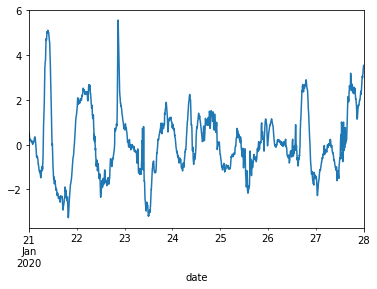

In [12]:
anom = model.get_anomaly(last_week)

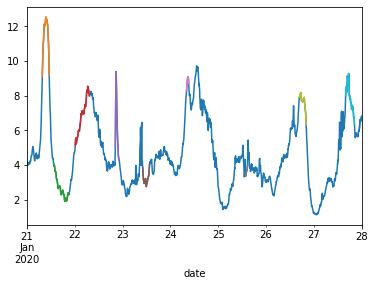

In [13]:
last_week.P1.plot()
for i in anom:
    i.P1.plot()

In [14]:
model.get_clusters(anom)

      max_P1    min_P1    min_P2    max_P2   mean_hum  change_hum  \
0  12.543763  9.136413  3.295233  4.849526  76.146824    2.706023   
1   4.115175  1.907841  0.797891  2.063081  77.911255    5.924368   
2   8.548551  5.150663  1.083656  2.072975  63.767722    4.948449   
3   9.396942  4.314914  1.700060  4.191157  65.562898    1.892655   
4   4.024880  2.761591  1.066468  1.419042  49.584785    8.713181   
5   9.101740  8.294688  3.958480  4.574202  70.911391    3.030962   
6   3.989449  3.373441  1.192264  1.553378  71.450710    1.152120   
7   8.186937  6.336191  2.933386  3.987281  74.259831    5.236814   
8   9.286715  6.381878  2.455629  4.672716  49.180064    3.785031   
9   6.817040  5.643451  2.364211  3.136675  59.582819   12.144340   

   change_temp  prec_amount  max_w_speed  min_w_speed  w_dir_sin_max  \
0     1.366688     0.502326          2.0          1.0      -0.801153   
1     0.771485     1.204301          2.0          2.0       0.408096   
2     1.268296     0.593

array([2, 2, 2, 2, 1, 2, 2, 2, 1, 2], dtype=int32)

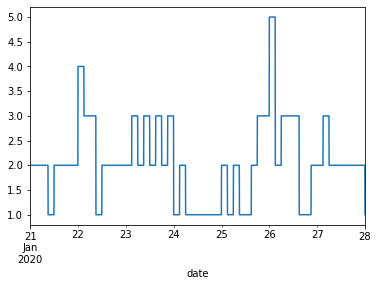

In [15]:
last_week.wind_speed.plot()

In [16]:
anom

[                            P1        P2      pressure  temperature  \
 date                                                                  
 2020-01-21 07:40:00   9.136413  3.901710  97183.036546     3.527656   
 2020-01-21 07:45:00   9.489516  4.014249  97169.183968     3.562675   
 2020-01-21 07:50:00   9.897393  4.064514  97150.586568     3.539936   
 2020-01-21 07:55:00  10.308540  4.165975  97153.533199     3.677947   
 2020-01-21 08:00:00  10.522951  4.173447  97118.362865     3.705193   
 2020-01-21 08:05:00  10.759977  4.047126  97152.362137     3.792316   
 2020-01-21 08:10:00  11.018522  4.532784  97116.767103     3.828466   
 2020-01-21 08:15:00  11.086571  4.252014  97126.897191     3.875678   
 2020-01-21 08:20:00  11.223157  4.349161  97099.462410     3.895934   
 2020-01-21 08:25:00  11.501745  4.607064  97112.323822     3.965603   
 2020-01-21 08:30:00  11.786570  4.828782  97097.092955     3.992494   
 2020-01-21 08:35:00  12.026808  4.534374  97061.337783     4.03